In [1]:
import os
from xml.etree.ElementInclude import include

import couchdb
import json
#from analysis import TwitterClassifier
from shapely.geometry import Polygon, box
from collections import defaultdict
import nltk
#nltk.download('wordnet')
import pandas as pd
import numpy as np

from textblob import TextBlob
import re

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_selection import f_regression
from empath import Empath


import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import ast
import wordcloud
from gensim.models import Phrases
from gensim.corpora.dictionary import Dictionary
from gensim import corpora
#from gensim.models import TfidfModel
from gensim.models.ldamodel import LdaModel

In [73]:
_id = []
user_id = []
location = []
time = []
text = []
rt_cnt = []
like_cnt = []
hashtag = []

_id_before = []
location_before = []
time_before = []
text_before = []


path = ['area-finding/tweepyUserTimeLine/tweet_melbourne0.json']
'''
,
        'area-finding/tweepyUserTimeLine/tweet_melbourne1.json',
        'area-finding/tweepyUserTimeLine/tweet_melbourne2.json',
        'area-finding/tweepyUserTimeLine/tweet_melbourne3.json',
        'area-finding/tweepyUserTimeLine/tweet_melbourne4.json',
        'area-finding/tweepyUserTimeLine/tweet_melbourne5.json',
        'area-finding/tweepyUserTimeLine/tweet_melbourne6.json',
        'area-finding/tweepyUserTimeLine/tweet_melbourne7.json']
'''
for ele in path:
    f = open(ele)
    line = f.readline()
    while line:
        line_dict = ast.literal_eval(line)

        d = line_dict['created_at'].split()

        if d[1] == 'Jan':
            month = '01'
        elif d[1] == 'Feb':
            month = '02'
        elif d[1] == 'March':
            month = '03'
        elif d[1] == 'Apr':
            month = '04'
        elif d[1] == 'May':
            month = '05'
        elif d[1] == 'Jun':
            month = '06'
        elif d[1] == 'Jul':
            month = '07'
        elif d[1] == 'Aug':
            month = '08'
        elif d[1] == 'Sep':
            month = '09'
        elif d[1] == 'Oct':
            month = '10'
        elif d[1] == 'Nov':
            month = '11'
        elif d[1] == 'Dec':
            month = '12'
        
        if int(d[5]) > 2019:
            _id.append(line_dict['_id'])
            user_id.append(line_dict['user_id'])
            location.append(line_dict['user_place'])
            text.append(line_dict['text'])
            time.append(d[5] + '-' + month)
            rt_cnt.append(line_dict['retweet_count'])
            like_cnt.append(line_dict['favorite_count'])
            hashtag.append(line_dict['hashtags'])
        
        if int(d[5]) > 2016 and int(d[5]) < 2020:
            _id_before.append(line_dict['_id'])
            location_before.append(line_dict['user_place'])
            text_before.append(line_dict['text'])
            time_before.append(d[5] + '-' + month)

        line = f.readline()

    f.close()

In [74]:
data = pd.DataFrame()

data['id'] = _id
data['user_id'] = user_id
data['location'] = location
data['text'] = text
data['time'] = time
data['rt'] = rt_cnt
data['like'] = like_cnt
data['hashtag'] = hashtag

data_before = pd.DataFrame()

data_before['id'] = _id_before
data_before['location'] = location_before
data_before['text'] = text_before
data_before['time'] = time_before

In [75]:
data = data.dropna()
data_before = data_before.dropna()

In [76]:
print(data.shape)
print(data_before.shape)

(1072116, 8)
(322248, 4)


In [77]:
data

,id,user_id,location,text,time,rt,like,hashtag
0,1523429978402353152,24113,"Brogo, Australia","@verbaliza Thanks! 😁\nToday will be pruning, h...",2022-05,0,0,[]
1,1523429478101569537,24113,"Brogo, Australia","@verbaliza Gloves :)\nLook, I essentially stop...",2022-05,0,0,[]
2,1523428432302211072,24113,"Brogo, Australia",@verbaliza Looking out on a dark winter seasca...,2022-05,0,1,[]
3,1523427931787522048,24113,"Brogo, Australia",@verbaliza Ex-Canberran here (now rural Bega V...,2022-05,0,1,[]
4,1523427255695065089,24113,"Brogo, Australia",@verbaliza Eliza.\nWinter is the BEST season.,2022-05,0,0,[]
...,...,...,...,...,...,...,...,...
1110757,1212707518792663041,997965797950566400,"Millgrove, Victoria",@nickcahill9 Don't even get excited anymore. D...,2020-01,0,1,[]
1110758,1212705513739128832,997965797950566400,"Millgrove, Victoria",RT @gumworld1976: Every retweet I donate $5 ev...,2020-01,253,0,[]
1110759,1212705235325423619,997965797950566400,"Millgrove, Victoria",@NedBalmeLives @rtralphy Even if you don't giv...,2020-01,0,0,[]
1110760,1212703556068708352,997965797950566400,"Millgrove, Victoria",Can all you climate change nuffies start gluin...,2020-01,0,0,[]


In [78]:
if_city = []
for idx,val in enumerate(data['location']):
    val = val.lower()
    if ('melbourne' in val) or ('sydney' in val) or ('brisbane' in val) or ('adelaide' in val):
        if_city.append(True)
    else: 
        if_city.append(False)

if_city_before = []
for idx,val in enumerate(data_before['location']):
    val = val.lower()
    if ('melbourne' in val) or ('sydney' in val) or ('brisbane' in val) or ('adelaide' in val):
        if_city_before.append(True)
    else: 
        if_city_before.append(False)

In [79]:
data['if_city'] = if_city
data = data[data['if_city'] == True]

data_before['if_city'] = if_city_before
data_before = data_before[data_before['if_city'] == True]

In [80]:
print(data.shape)
print(data_before.shape)


(612918, 9)
(217066, 5)


In [82]:
data

,id,user_id,location,text,time,rt,like,hashtag,if_city
3250,1523252190827380736,778395,"Sydney, Australia",Collage poetry\n@w1d1_app #challenge \n#inspir...,2022-05,0,0,"[challenge, inspiration]",True
3251,1523119190663520257,778395,"Sydney, Australia",Breakfast that looks pretty and tastes buoniss...,2022-05,0,0,[burchermuesli],True
3252,1522886951275220995,778395,"Sydney, Australia",#sushiboat at @zushi_sydney \n@telcus_au made ...,2022-05,0,0,[sushiboat],True
3253,1522878340289339392,778395,"Sydney, Australia",At the @mca_australia looking for inspiration ...,2022-05,0,0,[shells],True
3254,1522733153357496320,778395,"Sydney, Australia",Light and shadow\n@w1d1_app #challenge \n#insp...,2022-05,0,0,"[challenge, inspiration]",True
...,...,...,...,...,...,...,...,...,...
1109185,1221568332983304194,853536921032601600,"Brunswick, Melbourne","Stroll, Upfield Trail. https://t.co/3y4eJEk47d...",2020-01,2,9,[],True
1109186,1221365232070725632,853536921032601600,"Brunswick, Melbourne","Victorious, Kines ☕️\n.\n.\n.\n.\n.\n#coffee #...",2020-01,0,2,"[coffee, brunswickcoffee, hopestreet, dudeinwi...",True
1109187,1220900940275798016,853536921032601600,"Brunswick, Melbourne",MOTHERLOAD film screening. Presented by Tim Re...,2020-01,1,1,[],True
1109188,1219784345486946304,853536921032601600,"Brunswick, Melbourne",Attention: Brunswick https://t.co/0b2SE9WSYV,2020-01,2,6,[],True


In [12]:
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

emoji = re.compile("["  
    u"\U0001F600-\U0001F64F" 
    u"\U0001F300-\U0001F5FF" 
    u"\U0001F680-\U0001F6FF"  
    u"\U0001F1E0-\U0001F1FF"  
    u"\U00002500-\U00002BEF"  
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642" 
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  
    u"\u3030"
                  "]+", re.UNICODE)

In [13]:
def clean_text(text):

    #tokenizer = TweetTokenizer(r'\w+')

    text  = text.replace('\n'," ")
    text = re.sub('-'," ",text)
    text = re.sub(r"\d+/\d+/\d+", "", text) #日期，对主体模型没什么意义
    text = re.sub(r"[0-2]?[0-9]:[0-6][0-9]", "", text) #时间，没意义
    text = re.sub("http\S+", "", text)   # 去网址
    text = re.sub(r"bit.ly/\S+", '', text) # remove bit links
    text = text.strip('[link]') # remove other links
    text = text.lower()
    text = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text)
    text = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', text)
    text = re.sub(r"[\w]+@[\.\w]+", "", text) #邮件地址，没意义
    text = re.sub(r"/[a-zA-Z]*[:\//\]*[A-Za-z0-9\-_]+\.+[A-Za-z0-9\.\/%&=\?\-_]+/i", "", text) #网址，没意义
    text = re.sub(emoji, '', text) # remove emoji
    text = re.sub('[' + punctuation + ']+', ' ', text) # remove punctuation
    #text = tokenizer.tokenize(text)

    pure_text = ''
    for letter in text:
        if letter.isalpha() or letter ==' ':
            pure_text += letter
    text = ' '.join(word for word in pure_text.split() if len(word)>3)

    #lemmatizer = WordNetLemmatizer()
    #text = [[lemmatizer.lemmatize(word) for word in pure_text.split()]]

    return text

# cleaned_text = df['text']
cleaned_text = data['text'].apply(lambda x :clean_text(x))
cleaned_text_before = data_before['text'].apply(lambda x :clean_text(x))

In [14]:
data['cleaned_text'] = cleaned_text
data_before['cleaned_text'] = cleaned_text_before


In [15]:
data['cleaned_text'][3250]

'collage poetry challenge inspiration north ryde'

In [18]:
# 心理健康 keywords
with open('area-finding/mental_health_keywords_400.txt') as f:
    contents = f.read()
    mental_keywords = contents.split(',')


In [19]:
# 心理健康分类
def mental_health(dataset):

    if_mental = []

    for text in dataset['cleaned_text']:
        cnt = 0
        for word in mental_keywords:
            if word in text:
                cnt += 1
        if cnt > 0:
            if_mental.append(True)
        else:
            if_mental.append(False)
    
    return if_mental

data['if_mental'] = mental_health(data)
data_before['if_mental'] = mental_health(data_before)


In [20]:
# Data on mental health in all cities
data_mental = data[data['if_mental'] == True]
data_before_mental = data_before[data_before['if_mental'] == True]

In [21]:
print(data_mental.shape)
print(data_before_mental.shape)

(44699, 11)
(15326, 7)


In [84]:
# 疫情期间不区分城市的情绪相关推文数据输出
data_mental_js = data_mental.drop(columns = ['if_city', 'if_mental'], axis = 1).to_json(r'Mental.json', orient = 'records')

# Sentiment Analysis

In [22]:
def sentiment_analysis(dataset):

    sentiment_polarity = []
    #sentiment_subjectivity = []

    for val in dataset['cleaned_text']:
        val = TextBlob(val)
        sentiment_polarity.append(val.sentiment.polarity)
        #sentiment_subjectivity.append(val.sentiment.subjectivity)

    return sentiment_polarity

data_mental['sentiment_polarity'] = sentiment_analysis(data_mental)
#data_mental['sentiment_subjectivity'] = sentiment_subjectivity
data_before_mental['sentiment_polarity'] = sentiment_analysis(data_before_mental)
#data_mental['sentiment_subjectivity'] = sentiment_subjectivity

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [23]:
# remove neutral word 
data_mental = data_mental[data_mental['sentiment_polarity'] != 0]
data_before_mental = data_before_mental[data_before_mental['sentiment_polarity'] != 0]

In [24]:
print(data_mental.shape)
print(data_before_mental.shape)

(25714, 12)
(8891, 8)


In [25]:
def city_classifier(dataset):

    mel_idx = []
    syd_idx = []
    bris_idx = []
    ald_idx = []

    for idx,val in enumerate(dataset['location']):
        val = val.lower()
        if 'melbourne' in val:
            mel_idx.append(idx)
        if 'sydney' in val:
            syd_idx.append(idx)
        if 'brisbane' in val:
            bris_idx.append(idx)
        if 'adelaide' in val:
            ald_idx.append(idx)
    
    return mel_idx, syd_idx, bris_idx, ald_idx


In [36]:
# Distinguishing Cities
melbourne_mental = data_mental.iloc[city_classifier(data_mental)[0]]
sydney_mental = data_mental.iloc[city_classifier(data_mental)[1]]
brisbane_mental = data_mental.iloc[city_classifier(data_mental)[2]]
adelaide_mental = data_mental.iloc[city_classifier(data_mental)[3]]

melbourne_before_mental = data_before_mental.iloc[city_classifier(data_before_mental)[0]]
sydney_before_mental = data_before_mental.iloc[city_classifier(data_before_mental)[1]]
brisbane_before_mental = data_before_mental.iloc[city_classifier(data_before_mental)[2]]
adelaide_before_mental = data_before_mental.iloc[city_classifier(data_before_mental)[3]]

In [72]:
melbourne_mental

,id,user_id,location,text,time,rt,like,hashtag,if_city,cleaned_text,if_mental,sentiment_polarity,if_hashtag
3818,1515434909719957504,2485161,Melbourne,RT @mrpaddygilmore: John Hegarty: “a great ad ...,2022-04,5,0,[],True,john hegarty great product demo with twist thanks,True,0.500000,False
3841,1510224303765483524,2485161,Melbourne,@maddiemelb This one seemed on the cards. Feel...,2022-04,0,5,[],True,this seemed cards feels like were getting outc...,True,0.800000,False
3856,1508277915036704774,2485161,Melbourne,RT @UberFacts: Someone gets slapped at the Osc...,2022-04,4281,0,[],True,someone gets slapped oscars roughly once every...,True,-0.100000,False
3919,1496724388002996225,2485161,Melbourne,RT @JonathanLaNauze: Credlin frothing at the m...,2022-02,406,0,[],True,credlin frothing mouth about very rich people ...,True,0.487500,False
3944,1486892966148927491,2485161,Melbourne,"RT @visualizevalue: Failure is the frame, not ...",2022-01,3601,0,[],True,failure frame picture,True,-0.316667,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106310,1247108602889768961,3301298289,Melbourne Graduate School Of Education,To all the students out there worried about re...,2020-04,3,18,[],True,students there worried about remote learning w...,True,-0.300000,False
1106316,1243426966658666497,3301298289,Melbourne Graduate School Of Education,Hey Edufriends.. four days into planning for r...,2020-04,2,18,[],True,edufriends four days into planning remote lear...,True,-0.100000,False
1109105,1518194071587540992,853536921032601600,"Brunswick, Melbourne","RT @beneltham: Dying to know what ""Brunswick v...",2022-04,33,0,[],True,dying know what brunswick values might down lo...,True,-0.155556,False
1109116,1463687296578768896,853536921032601600,"Brunswick, Melbourne",RT @TimRRead: Moreland is named after a slave ...,2021-11,2,0,"[SpringSt, Moreland]",True,moreland named after slave plantation somethin...,True,0.800000,True


In [38]:
'''
# 数据输出为json
melbourne_mental_js = melbourne_mental.drop(columns = ['if_city', 'if_mental'], axis = 1).to_json(r'Melbourne_mental.json', orient = 'records')
sydney_mental_js = sydney_mental.drop(columns = ['if_city', 'if_mental'], axis = 1).to_json(r'Sydney_mental.json', orient = 'records')
brisbane_mental_js = brisbane_mental.drop(columns = ['if_city', 'if_mental'], axis = 1).to_json(r'Brisbane_mental.json', orient = 'records')
adelaide_mental_js = adelaide_mental.drop(columns = ['if_city', 'if_mental'], axis = 1).to_json(r'Adelaide_mental.json', orient = 'records')

melbourne_before_mental_js = melbourne_before_mental.drop(columns = ['if_city', 'if_mental'], axis = 1).to_json(r'Melbourne_before_mental.json', orient = 'records')
sydney_before_mental_js = sydney_before_mental.drop(columns = ['if_city', 'if_mental'], axis = 1).to_json(r'Sydney_before_mental.json', orient = 'records')
brisbane_mental_js = brisbane_before_mental.drop(columns = ['if_city', 'if_mental'], axis = 1).to_json(r'Brisbane_before_mental.json', orient = 'records')
adelaide_mental_js = adelaide_before_mental.drop(columns = ['if_city', 'if_mental'], axis = 1).to_json(r'Adelaide_before_mental.json', orient = 'records')
'''

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

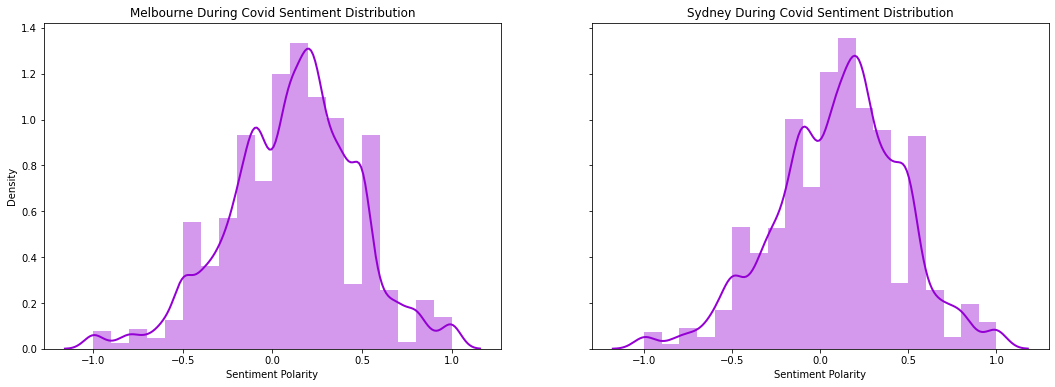

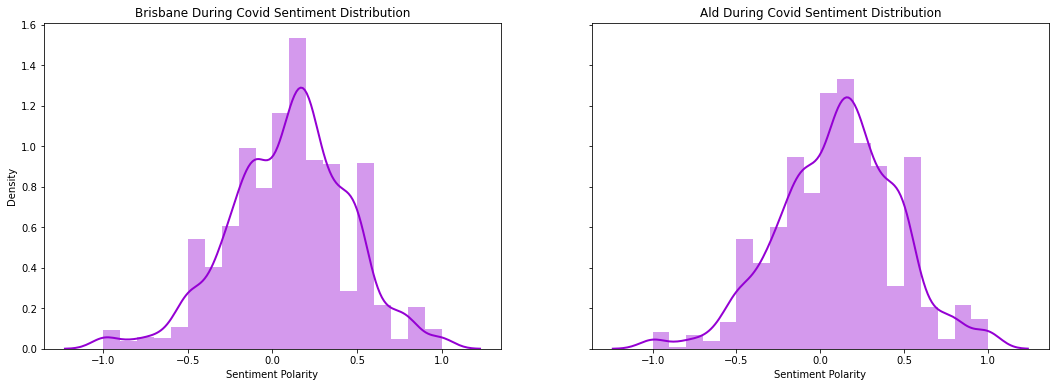

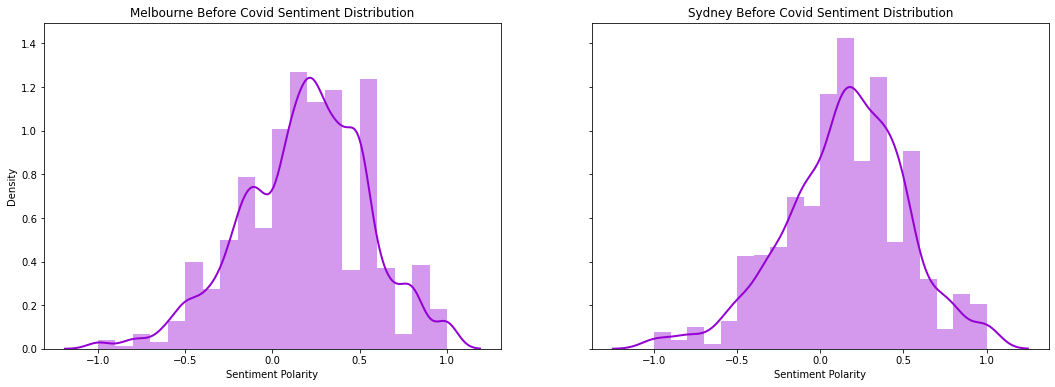

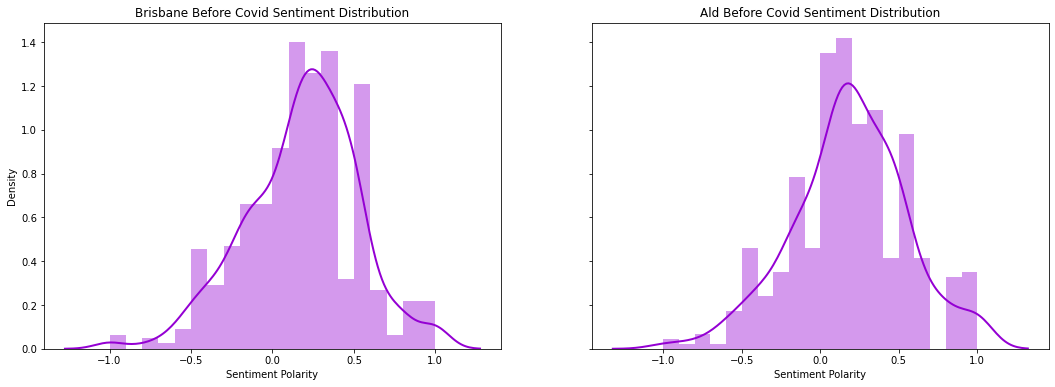

In [39]:
def sentiment_plot(city_1, city_2, title_list):
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    n_bins = 20
    sns.distplot(city_1["sentiment_polarity"], ax=ax[0], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})
    sns.distplot(city_2["sentiment_polarity"], ax=ax[1], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})
    #sns.distplot(city_3["sentiment_polarity"], ax=ax[2], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})
    #sns.distplot(city_4["sentiment_polarity"], ax=ax[3], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})

    for idx, subplot in enumerate(ax):
        #ax.tick_params(axis = "both", labelsize = 14)
        subplot.set_xlabel('Sentiment Polarity')
        subplot.set_ylabel('Density')
        subplot.set_title(title_list[idx])
        #subplot.set_xlabel('Sentiment Polarity')

title_list = ['Melbourne During Covid Sentiment Distribution', 'Sydney During Covid Sentiment Distribution']
sentiment_plot(melbourne_mental, sydney_mental, title_list)

title_list = ['Brisbane During Covid Sentiment Distribution', 'Ald During Covid Sentiment Distribution']
sentiment_plot(brisbane_mental, adelaide_mental, title_list)

title_list = ['Melbourne Before Covid Sentiment Distribution', 'Sydney Before Covid Sentiment Distribution']
sentiment_plot(melbourne_before_mental, sydney_before_mental, title_list)

title_list = ['Brisbane Before Covid Sentiment Distribution', 'Ald Before Covid Sentiment Distribution']
sentiment_plot(brisbane_before_mental, adelaide_before_mental, title_list)

In [397]:
'''
def sentiment_plot(city_1, city_2, title_list):
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    n_bins = 20
    sns.distplot(city_1["sentiment_subjectivity"], ax=ax[0], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})
    sns.distplot(city_2["sentiment_subjectivity"], ax=ax[1], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})
    #sns.distplot(city_3["sentiment_polarity"], ax=ax[2], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})
    #sns.distplot(city_4["sentiment_polarity"], ax=ax[3], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})

    for idx, subplot in enumerate(ax):
        #ax.tick_params(axis = "both", labelsize = 14)
        subplot.set_xlabel('Sentiment Subjectivity')
        subplot.set_ylabel('Density')
        subplot.set_title(title_list[idx])
        #subplot.set_xlabel('Sentiment Polarity')

title_list = ['Melbourne Sentiment Distribution', 'Sydney Sentiment Distribution']#, 'Brisbane Sentiment Distribution', 'Ald Sentiment Distribution']
sentiment_plot(melbourne_mental, sydney_mental, title_list)# brisbane_mental, ald_mental, title_list)

title_list = ['Brisbane Sentiment Distribution', 'Ald Sentiment Distribution']
sentiment_plot(brisbane_mental, adelaide_mental, title_list)
'''

'\ndef sentiment_plot(city_1, city_2, title_list):\n    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)\n    n_bins = 20\n    sns.distplot(city_1["sentiment_subjectivity"], ax=ax[0], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})\n    sns.distplot(city_2["sentiment_subjectivity"], ax=ax[1], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})\n    #sns.distplot(city_3["sentiment_polarity"], ax=ax[2], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})\n    #sns.distplot(city_4["sentiment_polarity"], ax=ax[3], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})\n\n    for idx, subplot in enumerate(ax):\n        #ax.tick_params(axis = "both", labelsize = 14)\n        subplot.set_xlabel(\'Sentiment Subjectivity\')\n        subplot.set_ylabel(\'Density\')\n        subplot.set_title(title_list[idx])\n        #subplot.set_xlabel(\'Sentiment Polarity\')\n\ntitle_list = [\'Melbourne Sentiment Distribution\', \'Sydne

In [40]:
# 判断不同地区mental相关的推文数量，判断是否宜居
print(melbourne_mental.shape)
print(sydney_mental.shape)
print(brisbane_mental.shape)
print(adelaide_mental.shape)
print('\n')
print(melbourne_before_mental.shape)
print(sydney_before_mental.shape)
print(brisbane_before_mental.shape)
print(adelaide_before_mental.shape)

(14010, 12)
(7703, 12)
(2191, 12)
(1810, 12)


(5927, 8)
(1720, 8)
(786, 8)
(458, 8)


In [41]:
melbourne_mental.head()

,id,user_id,location,text,time,rt,like,hashtag,if_city,cleaned_text,if_mental,sentiment_polarity
3818,1515434909719957504,2485161,Melbourne,RT @mrpaddygilmore: John Hegarty: “a great ad ...,2022-04,5,0,[],True,john hegarty great product demo with twist thanks,True,0.500000
3841,1510224303765483524,2485161,Melbourne,@maddiemelb This one seemed on the cards. Feel...,2022-04,0,5,[],True,this seemed cards feels like were getting outc...,True,0.800000
3856,1508277915036704774,2485161,Melbourne,RT @UberFacts: Someone gets slapped at the Osc...,2022-04,4281,0,[],True,someone gets slapped oscars roughly once every...,True,-0.100000
3919,1496724388002996225,2485161,Melbourne,RT @JonathanLaNauze: Credlin frothing at the m...,2022-02,406,0,[],True,credlin frothing mouth about very rich people ...,True,0.487500
3944,1486892966148927491,2485161,Melbourne,"RT @visualizevalue: Failure is the frame, not ...",2022-01,3601,0,[],True,failure frame picture,True,-0.316667


In [42]:
#import pyecharts.options as opts
#from example.commons import Faker
#from pyecharts.charts import Line

# 处理时间
start = '2020-01'
end = '2022-05'
t = pd.date_range(start=start, end=end, freq = 'M').tolist()
time_frame = []
for i in t:
    i = str(i)[:-12]
    time_frame.append(i)

In [43]:
melbourne_mental_cnt = melbourne_mental.sort_values(['time'], ascending=True).groupby('time')['time'].count()

In [44]:
data_covid = pd.read_csv('NCOV_COVID_Cases_by_LGA_20220511.csv')

In [45]:
data_covid.head()

,diagnosis_date,Localgovernmentarea
0,2020-03-11,Greater Geelong (C)
1,2020-03-08,Mornington Peninsula (S)
2,2020-03-09,Port Phillip (C)
3,2020-08-01,Whittlesea (C)
4,2020-03-01,Casey (C)


In [46]:
time_covid = []

for val in data_covid['diagnosis_date']:
    val = val[0:7]
    time_covid.append(val)

data_covid['time'] = time_covid

In [47]:
data_covid_cnt = data_covid.sort_values(['time'], ascending=True).groupby('time')['time'].count()

<function matplotlib.pyplot.show(close=None, block=None)>

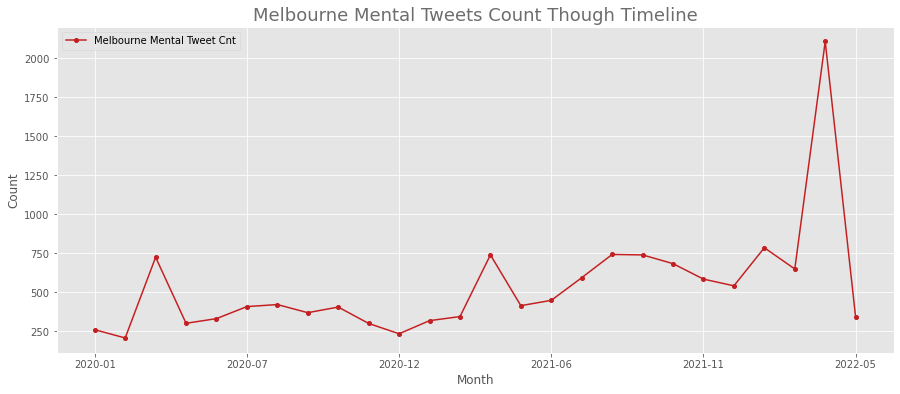

In [48]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(15, 6))
color_1 = '#6D6D6D'

melbourne_mental_cnt.plot(
    color = '#C42022',
    marker = 'o', markersize = 4,
    label = 'Melbourne Mental Tweet Cnt'
)
'''
data_covid_cnt.plot(
    color = '#C42022',
    marker = 'o', markersize = 4,
    label = 'Melbourne Covid Confirmed Cnt'
)
'''

plt.title('Melbourne Mental Tweets Count Though Timeline', color = color_1, fontsize = 18)
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

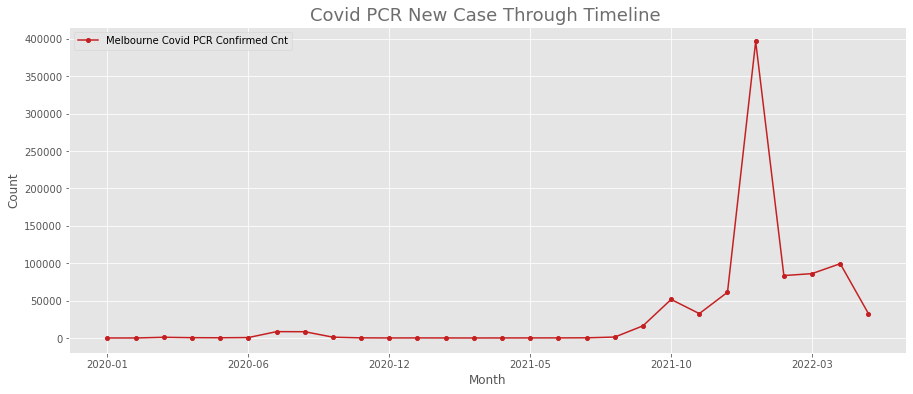

In [49]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(15, 6))
color_1 = '#6D6D6D'
'''
melbourne_mental_cnt.plot(
    color = '#C42022',
    marker = 'o', markersize = 4,
    label = 'Melbourne Mental Tweet Cnt'
)
'''
data_covid_cnt.plot(
    color = '#C42022',
    marker = 'o', markersize = 4,
    label = 'Melbourne Covid PCR Confirmed Cnt'
)


plt.title('Covid PCR New Case Through Timeline ', color = color_1, fontsize = 18)
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.show

# Word Cloud

In [50]:
stoplist = ['very', 'ourselves', 'am', 'doesn', 'through', 'me', 'against', 'up', 'just', 'her', 'ours', 
            'couldn', 'because', 'is', 'isn', 'it', 'only', 'in', 'such', 'too', 'mustn', 'under', 'their', 
            'if', 'to', 'my', 'himself', 'after', 'why', 'while', 'can', 'each', 'itself', 'his', 'all', 'once', 
            'herself', 'more', 'our', 'they', 'hasn', 'on', 'ma', 'them', 'its', 'where', 'did', 'll', 'you', 
            'didn', 'nor', 'as', 'now', 'before', 'those', 'yours', 'from', 'who', 'was', 'm', 'been', 'will', 
            'into', 'same', 'how', 'some', 'of', 'out', 'with', 's', 'being', 't', 'mightn', 'she', 'again', 'be', 
            'by', 'shan', 'have', 'yourselves', 'needn', 'and', 'are', 'o', 'these', 'further', 'most', 'yourself', 
            'having', 'aren', 'here', 'he', 'were', 'but', 'this', 'myself', 'own', 'we', 'so', 'i', 'does', 'both', 
            'when', 'between', 'd', 'had', 'the', 'y', 'has', 'down', 'off', 'than', 'haven', 'whom', 'wouldn', 
            'should', 've', 'over', 'themselves', 'few', 'then', 'hadn', 'what', 'until', 'won', 'no', 'about', 
            'any', 'that', 'for', 'shouldn', 'don', 'do', 'there', 'doing', 'an', 'or', 'ain', 'hers', 'wasn', 
            'weren', 'above', 'a', 'at', 'your', 'theirs', 'below', 'other', 'not', 're', 'him', 'during', 'which',
            'im', 'dont', 'havent', 'like', 'one', 'get', 'first', 'time', 'many', 'would', 'today']

In [51]:
def takeCnt(x):
    return x[1]

def generate_word_list(dataset):
    word_text = [[word for word in doc.lower().split() if word not in stoplist] for doc in dataset['cleaned_text']]
    word_str = ''
    for ele in word_text:
        for val in ele:
            word_str += val + ' '
    
    return word_str


def word_cnt(word_str):

    words = word_str.split()
    word_cnt = {}

    for word in words:
        word_cnt[word] = word_cnt.get(word, 0) + 1

    items = list(word_cnt.items())
    items.sort(key = takeCnt, reverse = True)

    for i in range(10):
        key, value = items[i]
        print('{0:<10}{1:>5}'.format(key, value))


def word_cnt_plt(word_str):

    words = word_str.split()
    word_cnt = {}

    for word in words:
        word_cnt[word] = word_cnt.get(word, 0) + 1

    items = list(word_cnt.items())
    items.sort(key = takeCnt, reverse = True)

    return items

In [52]:
# melbourne  Calculating word frequency
print('Melbourne word count: ')
word_cnt(generate_word_list(melbourne_mental))

# sydney  Calculating word frequency
print('Sydney word count: ')
word_cnt(generate_word_list(sydney_mental))

# brisbane  Calculating word frequency
print('Brisbane word count: ')
word_cnt(generate_word_list(brisbane_mental))

# ald  Calculating word frequency
print('Ald word count: ')
word_cnt(generate_word_list(adelaide_mental))

Melbourne word count: 
media      1051
people      721
health      520
good        475
social      460
mental      426
covid       417
event       403
great       399
right       352
Sydney word count: 
media       752
people      383
social      290
covid       253
event       252
good        225
great       209
morrison    203
abuse       203
right       179
Brisbane word count: 
media       220
people      123
morrison    106
good         77
know         71
covid        66
confirmed    62
social       60
medical      60
news         56
Ald word count: 
media       128
people      101
good         64
back         63
great        58
care         57
health       53
covid        53
australia    48
mental       47


In [53]:
def generate_word_cloud(dataset):
    txt = generate_word_list(dataset)
    font_path = os.environ.get('FONT_PATH', '/Library/Fonts/Times New Roman.ttf')
    w = wordcloud.WordCloud(font_path = font_path, width = 800, height = 600, max_words = 40, font_step = 3)
    w.generate(txt)
    w.to_file('wordcloud.png')

    print('word cloud generated successfully!')

In [189]:
generate_word_cloud(melbourne_mental)

word cloud generated successfully!


# Hashtag Analysis

In [54]:
if_hashtag = []
for idx,val in enumerate(melbourne_mental['hashtag']):
    if len(val) > 0:
        if_hashtag.append(True)
    else:
        if_hashtag.append(False)

melbourne_mental['if_hashtag'] = if_hashtag
melbourne_mental_hashtag = melbourne_mental[melbourne_mental['if_hashtag'] == True]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [56]:
def generate_hashtag_list(dataset):
    word_str = ''
    for ele in dataset['hashtag']:
        for val in ele:
            word_str += val + ' '
    
    return word_str

In [57]:
word_cnt(generate_hashtag_list(melbourne_mental_hashtag))

auspol       94
COVID19      36
AppleEvent   31
Oscars       22
votethemout   22
MurdochGutterMedia   18
coronavirus   18
COVID19Aus   14
TheMotherFault   13
BREAKING     12


/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show(close=None, block=None)>

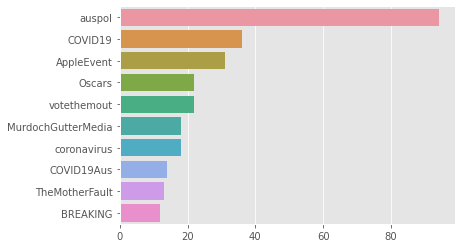

In [88]:
x = []
y = []
for val in word_cnt_plt(generate_hashtag_list(melbourne_mental_hashtag))[0:10]:
    key, value = val
    x.append(key)
    y.append(value)

sns.barplot(y, x)
plt.show

### First Wave (2020-03 to 2020-05)

In [100]:
melbourne_mental_hashtag_w1 = melbourne_mental_hashtag.loc[(melbourne_mental_hashtag['time'] >= '2020-03') & (melbourne_mental_hashtag['time'] <= '2020-05')] 
melbourne_mental_hashtag_w1 = melbourne_mental_hashtag_w1.reset_index(drop = True)


In [114]:
def hashtag_attention(dataset):

    hashtag_score = {}

    for idx, val in enumerate(dataset['hashtag']):
        for hashtag in val:
            hashtag_score[hashtag] = hashtag_score.get(hashtag, 0) + int(dataset['rt'][idx])*5 + int(dataset['like'][idx])

    items = list(hashtag_score.items())
    items.sort(key = takeCnt, reverse = True)

    return items

/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show(close=None, block=None)>

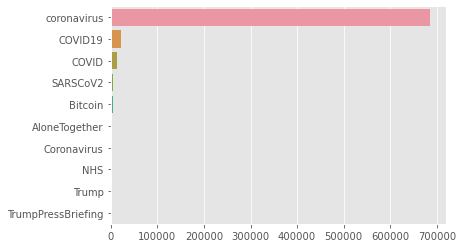

In [116]:
x = []
y = []
for val in hashtag_attention(melbourne_mental_hashtag_w1)[0:10]:
    key, value = val
    x.append(key)
    y.append(value)

sns.barplot(y, x)
plt.show

### Second Wave (2020-06 to 2020-10)

In [105]:
melbourne_mental_hashtag_w2 = melbourne_mental_hashtag.loc[(melbourne_mental_hashtag['time'] >= '2020-06') & (melbourne_mental_hashtag['time'] <= '2020-10')] 
melbourne_mental_hashtag_w2 = melbourne_mental_hashtag_w2.reset_index(drop = True)


/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show(close=None, block=None)>

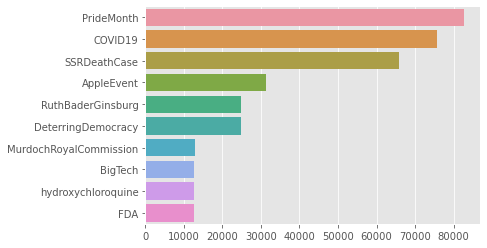

In [117]:
x = []
y = []
for val in hashtag_attention(melbourne_mental_hashtag_w2)[0:10]:
    key, value = val
    x.append(key)
    y.append(value)

sns.barplot(y, x)
plt.show

### Third Wave (2021-07 to present)

In [108]:
melbourne_mental_hashtag_w3 = melbourne_mental_hashtag.loc[(melbourne_mental_hashtag['time'] >= '2021-07')] 
melbourne_mental_hashtag_w3 = melbourne_mental_hashtag_w3.reset_index(drop = True)


/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show(close=None, block=None)>

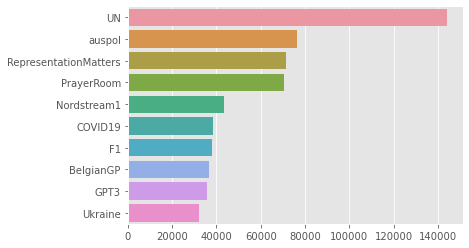

In [118]:
x = []
y = []
for val in hashtag_attention(melbourne_mental_hashtag_w3)[0:10]:
    key, value = val
    x.append(key)
    y.append(value)

sns.barplot(y, x)
plt.show

# Topic Modeling

In [60]:
new_stopword = nltk.corpus.stopwords.words('english')
repeated_words = ['ever', 'start', 'pre', 'amp', '&amp', 'may', 'and', 'when', 'what', 'who', 'why', 'how',
                  'this', 'your', 'mine', 'their', 'her', 'his', 'that']

for ele in repeated_words:
    new_stopword.append(ele)

In [61]:
tweets = melbourne_mental['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in new_stopword]))

tokenizer = TweetTokenizer(r'\w+')
tweets = [tokenizer.tokenize(tweet) for tweet in tweets]

lemmatizer = WordNetLemmatizer()
tweets = [[lemmatizer.lemmatize(token) for token in tweet] for tweet in tweets]

In [62]:
bigram = Phrases(tweets, min_count = 10)
trigram = Phrases(bigram[tweets])

for i in range(len(tweets)):
    for val in bigram[tweets[i]]:
        if '_' in val:
            tweets[i].append(val)
    for val in trigram[tweets[i]]:
        if '_' in val:
            tweets[i].append(val)

dictionary = Dictionary(tweets)
dictionary.filter_extremes(no_below=10, no_above=0.2)

corpus = [dictionary.doc2bow(tweet) for tweet in tweets]

In [63]:
topic_num = 5

temp = dictionary[0]
id2word = dictionary.id2token

lda_model = LdaModel(corpus = corpus, id2word = id2word, chunksize = len(melbourne_mental)/5,
                     alpha = 'auto', eta = 'auto', iterations = 20, num_topics = topic_num, 
                     passes = 20, eval_every = 1, random_state = np.random.RandomState(100))

print(lda_model.print_topics())

[(0, '0.017*"event" + 0.015*"best" + 0.013*"better" + 0.013*"recovery" + 0.013*"night" + 0.012*"comedy" + 0.012*"avoid" + 0.012*"last_night" + 0.011*"watch" + 0.010*"doctor"'), (1, '0.018*"confirmed" + 0.013*"medical" + 0.011*"government" + 0.011*"case" + 0.010*"failure" + 0.010*"prime_minister" + 0.009*"young_people" + 0.009*"people" + 0.009*"young" + 0.008*"confirmed_case"'), (2, '0.106*"mental_health" + 0.050*"health" + 0.040*"mental" + 0.025*"scott_morrison" + 0.012*"havent_seen" + 0.012*"seen" + 0.011*"condition" + 0.011*"scott" + 0.010*"morrison" + 0.010*"death"'), (3, '0.088*"social_medium" + 0.087*"medium" + 0.037*"social" + 0.015*"aged_care" + 0.013*"care" + 0.010*"eden_park" + 0.007*"aged" + 0.007*"trump" + 0.007*"early" + 0.006*"kind"'), (4, '0.011*"like" + 0.011*"people" + 0.010*"year" + 0.010*"good" + 0.010*"time" + 0.009*"today" + 0.009*"event" + 0.008*"first" + 0.008*"great" + 0.007*"many"')]


# Suburb Analysis

In [65]:
user_id = []
user_sub = []

f = open('area-finding/authorListAdd.json')
line = f.readline()
line = line[1:-1].split('},')
for val in line:
    val = val + '}'
    sub = int(val[val.find('suburb": ') + 9:val.find('}')])

    if sub > 0:
        user_id.append(val[val.find('_id": ') + 6:val.find(', "coor')])
        user_sub.append(sub)

f.close()

In [66]:
melbourne_user_info = pd.DataFrame()
melbourne_user_info['user_id'] = user_id
melbourne_user_info['user_suburb'] = user_sub

In [67]:
# 墨尔本地区 inner join
melbourne_mental_sub = melbourne_mental.merge(melbourne_user_info, on = 'user_id')

In [87]:
'''
# 墨尔本地区带有Suburb ID的数据输出
melbourne_mental_sub_js = melbourne_mental_sub.drop(columns = ['if_city', 'if_mental', 'if_hashtag'], axis = 1).to_json(r'Melbourne_mental_suburb.json', orient = 'records')
'''

In [69]:
#Total number of sentiment-related tweets per suburb, number of positive, number of negative (during the epidemic)
suburb_mental_cnt = melbourne_mental_sub.groupby('user_suburb')['user_suburb'].count()
suburb_mental_positive_cnt = melbourne_mental_sub[melbourne_mental_sub['sentiment_polarity'] > 0].groupby('user_suburb')['user_suburb'].count()
suburb_mental_negative_cnt = melbourne_mental_sub[melbourne_mental_sub['sentiment_polarity'] < 0].groupby('user_suburb')['user_suburb'].count()


In [70]:
# Calculate the average number of retweets and likes of sentiment-related tweets, positive tweets, negative tweets per suburb on average (during the epidemic)
suburb_mental_rt_sum = (melbourne_mental_sub.groupby('user_suburb')['rt'].sum()) / suburb_mental_cnt
suburb_mental_rt_pos_sum = (melbourne_mental_sub[melbourne_mental_sub['sentiment_polarity'] > 0].groupby('user_suburb')['rt'].sum()) / suburb_mental_cnt
suburb_mental_rt_neg_sum = (melbourne_mental_sub[melbourne_mental_sub['sentiment_polarity'] < 0].groupby('user_suburb')['rt'].sum()) / suburb_mental_cnt